In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.applications import vgg19
from PIL import Image as PILImage

In [ ]:
directory = "./gdrive/My Drive/style-transfer"

base_image_path = os.path.join(directory, "messi.jpg")
style_reference_image_path = os.path.join(directory, "2_style.jpeg")

In [ ]:
width, height = keras.utils.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

<Figure size 640x480 with 0 Axes>

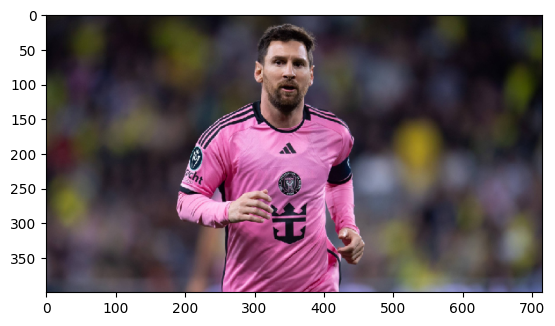

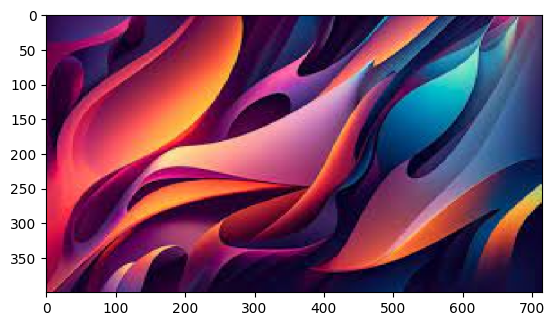

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.imshow(keras.utils.load_img(base_image_path, target_size=(img_nrows, img_ncols)))
plt.figure()

plt.imshow( keras.utils.load_img(style_reference_image_path, target_size=(img_nrows, img_ncols)))
plt.figure()


In [ ]:
def preprocess_image(image_path):
    img = keras.utils.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

In [ ]:
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [ ]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

In [ ]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))

In [ ]:
def content_loss(base, combination):
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(combination - base)/ (4.0 * (channels) * (size)))

In [ ]:
def total_variation_loss(x):
    a = tf.square(x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :])
    b = tf.square(x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [ ]:
model = vgg19.VGG19(weights="imagenet", include_top=False)

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
for layer in model.layers:
  print (layer.name)

In [ ]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

In [ ]:
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [ ]:
style_layer_names = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]
content_layer_name = "block5_conv2"

In [ ]:
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

In [ ]:
def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat([base_image, style_reference_image, combination_image], axis=0)
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(base_image_features, combination_features)
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [ ]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [ ]:
optimizer = keras.optimizers.SGD(keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96))

In [ ]:
base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

In [ ]:
iterations = 2800
loss_values = []

for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(combination_image, base_image, style_reference_image )
    loss_values.append(loss)
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = "stylised_image.png"
        keras.utils.save_img(fname, img)

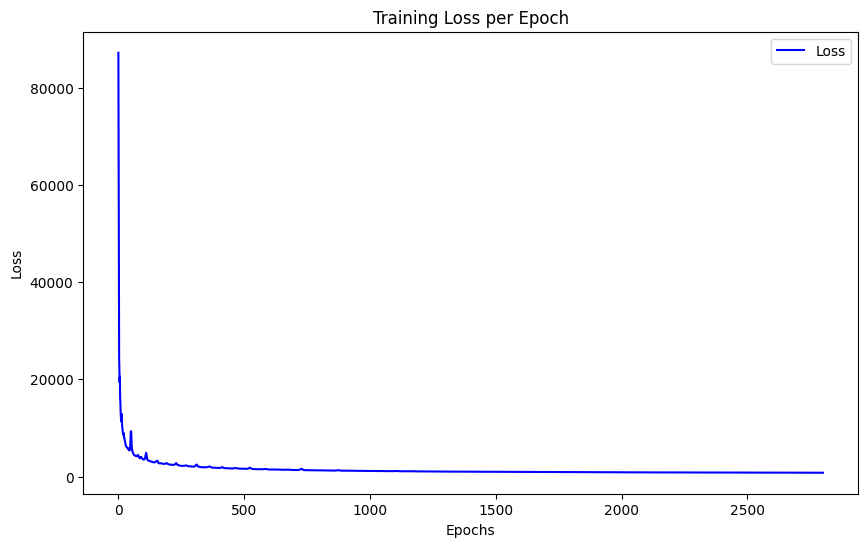

In [ ]:

epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, linestyle='-', color='b', label='Loss')

plt.title('Training Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()

plt.show()

In [ ]:
filename = "stylised_image.png"
image_path = os.path.join(directory, filename)
PILImage.open("stylised_image.png").save(image_path)

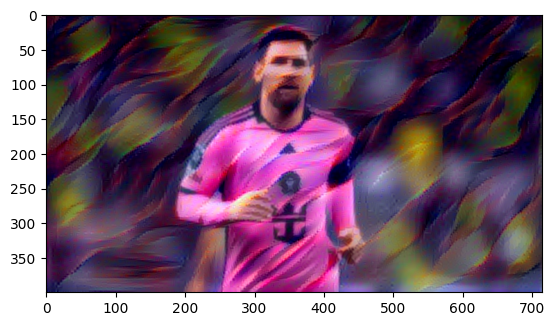

In [ ]:
plt.imshow(img)
plt.show()